<a href="https://colab.research.google.com/github/GuysBarash/Bargaining/blob/main/bargaining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [27]:
import random
import sys
import networkx as nx
import matplotlib.pyplot as plt
import time

import pandas as pd
import numpy as np

from copy import copy
from collections import deque

import itertools
from tqdm import tqdm

In [28]:
colab_mode = 'google.colab' in sys.modules
if colab_mode:
  from IPython.display import clear_output 
  !apt install libgraphviz-dev
  !pip install pygraphviz
  import pygraphviz as pgv
  from networkx.drawing.nx_agraph import graphviz_layout
  clear_output()

# Auxiliary functions

In [29]:
def coalition_keys_to_str(c):
    c_list = [c_t + 1 for c_t in c]
    r = '_'.join([str(c_int) for c_int in c_list])
    return r


def str_to_coalition_keys(s):
    r = sorted(list(set([int(t) - 1 for t in s.split('_')])))
    return r

# Classes

In [30]:
class MetaCoalition:
    curr_idx = 0

    def __init__(self, key, value, number_of_players=3):
        self.idx = MetaCoalition.curr_idx + 1
        self.number_of_players = number_of_players
        MetaCoalition.curr_idx += 1

        key_int_l = [int(t) for t in key.split('_')]
        key_int_l.sort()
        self.coalition_members = key_int_l
        self.key = '_'.join([str(t) for t in key_int_l])
        self.sig = self.key

        self.coalition_vectors = [0] * self.number_of_players
        for p in key_int_l:
            self.coalition_vectors[p - 1] = 1

        self.possible_adversaries_vector = [0] * self.number_of_players
        self.possible_adversaries = list()
        for i in range(len(self.coalition_vectors)):
            if self.coalition_vectors[i] == 0:
                self.possible_adversaries += [i]
                self.possible_adversaries_vector[i] = 1

        self.value = value

    def __str__(self):
        return self.sig

    def __contains__(self, key):
        return key in self.coalition_members

    def check_overlap(self, mc):
        overlaps = list(set(self.coalition_members) & set(mc.coalition_members))
        return len(overlaps) > 0

In [31]:
class Coalition:

    @staticmethod
    def reduce_coalition(coalitions):
        if len(coalitions) == 0:
            return list()

        optimals = list()
        adversaries = list(set([c.last_adv for c in coalitions]))
        for adv_p in adversaries:
            coalitions_with_leader = [c for c in coalitions if c.last_adv == adv_p]
            optimal_coalition = max(coalitions_with_leader, key=lambda c: c.get_last_adv_value())

            # Option B: split in case of equilibrium
            optimal_value = optimal_coalition.get_last_adv_value()
            optimals_p = [c for c in coalitions_with_leader if c.get_last_adv_value() == optimal_value]

            optimals += optimals_p

        return optimals

    def __init__(self, payoffs, subcoalitions, last_adv, info):
        self.info = info
        self.last_adv = last_adv
        self.all_metacoalitions = info.get('metacoalitions', dict())
        self.subcoalitions = subcoalitions
        self.players_count = info.get('players_count', 50)
        self.bargain_step = info.get('bargain_step', 50)
        self.payoff = np.array(payoffs)
        self.players_vector = [int(t > 0) for t in self.payoff]
        self.players = [p + 1 for p in range(len(self.players_vector)) if self.players_vector[p] > 0]
        self.adversaries_vector = [int(t == 0) for t in self.payoff]
        self.adversaries = [p + 1 for p in range(len(self.adversaries_vector)) if self.adversaries_vector[p] > 0]
        self.next = list()
        self.sig = None
        self.sig = self._sig()

    def get_last_adv_value(self):
        return self.payoff[self.last_adv - 1]

    def _sig(self):
        if self.sig is None:
            self.sig = '_'.join([str(po) for po in self.payoff])
            self.sig = f'({self.last_adv})' + self.sig
        return self.sig

    def __str__(self):
        return self.sig

    def expand(self):
        self.next = list()
        returns = list()

        for adv_p in self.adversaries:
            known_metacoalitions_with_leader = [k for k, mc in self.all_metacoalitions.items() if
                                                adv_p in mc]
            for mc_key in known_metacoalitions_with_leader:
                mc = self.all_metacoalitions[mc_key]
                mc_value = mc.value
                payoffs_c = [0] * self.players_count

                # Set value of all non-leaders to the bargaining step
                for player_j in mc.coalition_members:
                    if player_j != adv_p:
                        payoffs_c[player_j - 1] = self.payoff[player_j - 1] + bargain_step

                adv_value = mc_value - sum(payoffs_c)
                payoffs_c[adv_p - 1] = adv_value
                if adv_value > 0:
                    current_mcs = self.subcoalitions
                    remain_mcs = [mc_t for mc_t in current_mcs if not mc.check_overlap(mc_t)]
                    for r_mc in remain_mcs:
                        for old_player in r_mc.coalition_members:
                            payoffs_c[old_player - 1] = self.payoff[old_player - 1]
                    n_coalition = Coalition(payoffs_c, [mc] + remain_mcs, last_adv=adv_p, info=self.info)
                    self.next.append(n_coalition.sig)
                    returns.append(n_coalition)
                else:
                    # leader <= 0, coalition not relevant
                    pass
        return returns

    def set_edges(self, edges):
        self.next = copy(edges)

    def get_as_edge(self):
        r = [(self.sig, t_next) for t_next in self.next]
        return r

# Roots of negotiation

In [32]:
def get_all_root(bargain_step, metacoalitions, info):
    roots = list()
    players = list(range(1, players_count + 1))  # Note, the key of player N, is N+1
    for leader_p in players:
        known_coalitions_with_leader = [c for c in metacoalitions.values() if leader_p in c.coalition_members]
        for coalition_c in known_coalitions_with_leader:
            coalition_c_sig = coalition_c.sig
            coalition_c_value = coalition_c.value
            root = [0] * players_count

            # Set value of all non-leaders to the bargaining step
            for player_j in coalition_c.coalition_members:
                if player_j != leader_p:
                    root[player_j - 1] = bargain_step

            leader_value = coalition_c_value - sum(root)
            root[leader_p - 1] = leader_value
            if leader_value > 0:
                coalition = Coalition(root, [coalition_c], leader_p, info=info)
                roots.append(coalition)
    return roots

# Problem parameters

The payoff of each coalition

In [33]:
coalitions_value = dict()

In [34]:
coalitions_value = dict()
coalitions_value['1_2'] = 1000
coalitions_value['1_3'] = 1000
coalitions_value['1_4'] = 1000
coalitions_value['2_3_4'] = 1000

In [35]:
bargain_step = 50
default_coalition_value = 0

In [36]:
players_count = len(
    list(set(itertools.chain.from_iterable([str_to_coalition_keys(t) for t in coalitions_value.keys()]))))
print(f"Players in game: {players_count}")

Players in game: 4


#Bargaining starting points

In [37]:
metacoalitions = [MetaCoalition(k, v, number_of_players=players_count) for k, v in coalitions_value.items()]
metacoalitions = {mc.sig: mc for mc in metacoalitions}

In [38]:
info = dict()
info['metacoalitions'] = metacoalitions
info['players_count'] = players_count
info['bargain_step'] = bargain_step
info['default_coalition_value'] = default_coalition_value

In [39]:
roots = get_all_root(
    bargain_step, metacoalitions,
    info=info,
)
print(f"Roots detected: {len(roots)}")

Roots detected: 9


# Simulation

BFS

In [40]:
# BFS
g = dict()
q = []
visited = dict()

for root in roots:
    g[root.sig] = root
    q.append(root.sig)

while len(q) > 0:
    node_sig = q.pop(0)
    node = g[node_sig]
    if node_sig in visited:
        continue
    else:
        visited[node_sig] = True

        n_nodes = node.expand()
        n_nodes = Coalition.reduce_coalition(n_nodes)
        node.set_edges([t._sig() for t in n_nodes])
        for n_node in n_nodes:
            if n_node is None:
                continue
            elif n_node.sig in visited:
                continue
            else:
                g[n_node.sig] = n_node
                q.append(n_node.sig)


In [41]:
# Build graph
nodes = list(g.keys())
edges = list()
for n_node_sig in nodes:
    edges += g[n_node_sig].get_as_edge()

OG = nx.DiGraph()
for n_node in nodes:
    OG.add_node(n_node, name=n_node)
OG.add_edges_from(edges)

In [42]:
# Find end points
end_points = list()
for node_sig, node in g.items():
    e_t = node.get_as_edge()
    if e_t is None or len(e_t) == 0:
        end_points.append(node_sig)

# Find cycles
cycles = list(nx.algorithms.simple_cycles(OG))

In [43]:
print(f"Cycles: {len(cycles)}")
print(f"DeadEnds: {len(end_points)}")
possible_endings = len(cycles) + len(end_points)
print(f"Possible endings: {possible_endings}")

Cycles: 5
DeadEnds: 0
Possible endings: 5


# Visualization

In [44]:
color_map = []
for node in OG:
  color = 'ORANGE'
  for cycle in cycles:
    if node in cycle:
      color = 'RED'
  if node in end_points:
    color = 'YELLOW'
  color_map += [color]

Plot all

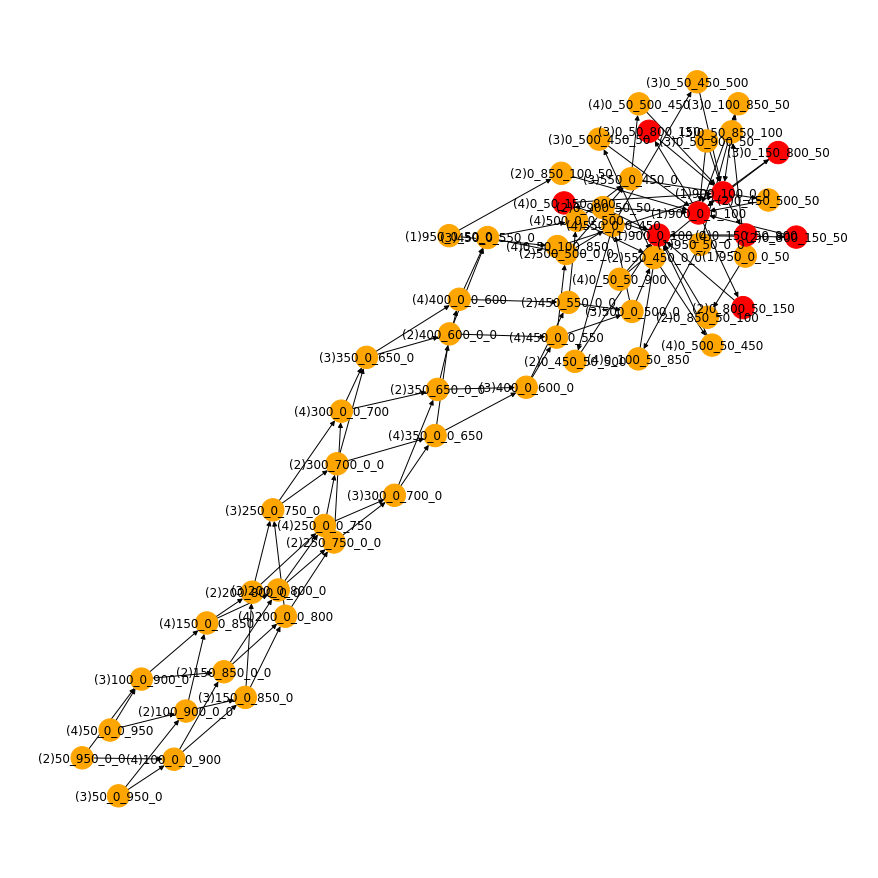

In [45]:
node_size = 500
font_size = 10
plt.figure(3,figsize=(12,12)) 

nx.draw(OG,node_color=color_map,node_size=node_size, with_labels=True)
plt.show()

Plot just the loops

In [46]:
# Plot just loops
nodes_sig = list()
if len(cycles) > 0:
    nodes_sig = list(set.union(*[set(s) for s in cycles]))
edges = list()
for n_node_sig in nodes_sig:
    e = g[n_node_sig].get_as_edge()
    e = [et for et in e if et[1] in nodes_sig]
    edges += e

G = nx.DiGraph()
for n_node in nodes_sig + end_points:
    G.add_node(n_node, name=n_node)
G.add_edges_from(edges)

In [47]:
# Print components
components = [list(qt) for qt in nx.strongly_connected_components(G)]
print(f"Stable Components: ({len(components)})")
for idx, comp in enumerate(components):
    print(f'[{idx + 1}/{len(components)}]\t')
    for ccomp_prt in comp:
      print(ccomp_prt)

Stable Components: (1)
[1/1]	
(3)0_50_800_150
(3)0_150_800_50
(1)900_0_100_0
(1)900_100_0_0
(4)0_50_150_800
(2)0_800_50_150
(4)0_150_50_800
(2)0_800_150_50
(1)900_0_0_100


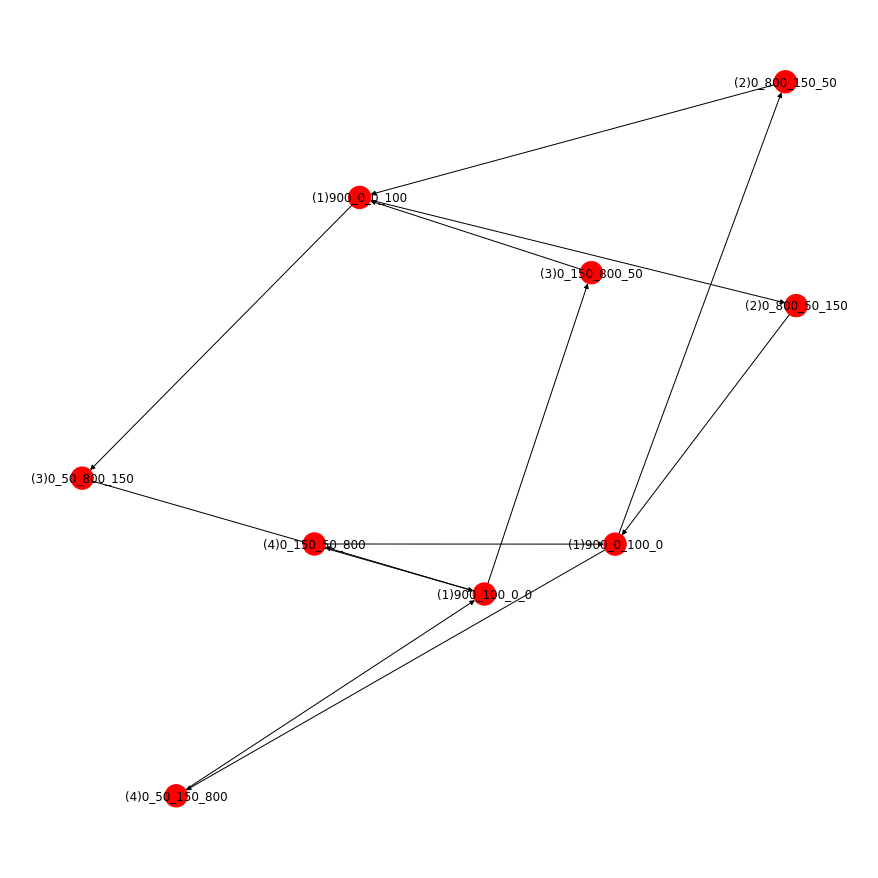

In [48]:
# Plot all graph
node_size = 500
font_size = 10
plt.figure(3, figsize=(12, 12))

color_map = []
for node in G:
  color = 'ORANGE'
  for cycle in cycles:
    if node in cycle:
      color = 'RED'
  if node in end_points:
    color = 'YELLOW'
  color_map += [color]

nx.draw(G,node_color=color_map, node_size=node_size, with_labels=True)
plt.show()

# Steady state exploration

In [49]:
histdf = pd.DataFrame(index=OG.nodes, columns=range(1, len(components) + 1), data=0)
for comp_idx, comp in enumerate(components):
    s_node = np.random.choice(comp)
    hist_comp = dict()
    hist_comp[s_node] = 1
    itrs = 10 ** 5
    for i in tqdm(range(itrs), desc=f'Random walk on component {comp_idx + 1}/{len(components)}'):
        options_edges = list(OG.out_edges(s_node))
        if len(options_edges) == 0:
          time.sleep(0.4)
          print(f"> Component {comp_idx+1} was broken")
          time.sleep(0.4)
          break
        selected_edge = options_edges[np.random.randint(len(options_edges))]
        s_node = selected_edge[1]
        hist_comp[s_node] = hist_comp.get(s_node, 0) + 1
    sr = pd.Series(hist_comp)
    histdf.loc[sr.index, comp_idx + 1] = sr
histdf = histdf[histdf.sum(axis=1) > 0]


Random walk on component 1/1: 100%|██████████| 100000/100000 [00:01<00:00, 63316.62it/s]


This is how many times each state is visited (Using drunk-walk)

In [50]:
from google.colab import data_table
data_table.DataTable(histdf, include_index=True)

,1
(1)900_0_100_0,16696
(1)900_0_0_100,16639
(1)900_100_0_0,16665
(2)0_800_150_50,8341
(4)0_50_150_800,8355
(2)0_800_50_150,8330
(3)0_50_800_150,8310
(3)0_150_800_50,8299
(4)0_150_50_800,8366


This is the drunk walk - normalized

In [51]:
data_table.DataTable((histdf / histdf.sum(axis=0)).round(4), include_index=True)

,1
(1)900_0_100_0,0.1670
(1)900_0_0_100,0.1664
(1)900_100_0_0,0.1666
(2)0_800_150_50,0.0834
(4)0_50_150_800,0.0835
(2)0_800_50_150,0.0833
(3)0_50_800_150,0.0831
(3)0_150_800_50,0.0830
(4)0_150_50_800,0.0837


This is the steady state, as calculated using eignvectors

In [52]:
# adjacency matrix calculations
adj = nx.adjacency_matrix(OG).todense()
adj = adj / adj.sum(axis=1)

def steady_state_prop(p):
    dim = p.shape[0]
    q = (p - np.eye(dim))
    ones = np.ones(dim)
    q = np.c_[q, ones]
    QTQ = np.dot(q, q.T)
    bQT = np.ones(dim)
    return np.linalg.solve(QTQ, bQT)


steady_state_matrix = steady_state_prop(adj)
steady_state_matrix = steady_state_matrix.round(4)
eps = 0.00001
ssdf = pd.Series(index=OG.nodes, data=steady_state_matrix, dtype=float)
ssdf = ssdf[ssdf > eps]
data_table.DataTable(pd.DataFrame(ssdf))

,0
(1)900_0_100_0,0.1667
(1)900_0_0_100,0.1667
(1)900_100_0_0,0.1667
(2)0_800_150_50,0.0833
(4)0_50_150_800,0.0833
(2)0_800_50_150,0.0833
(3)0_50_800_150,0.0833
(3)0_150_800_50,0.0833
(4)0_150_50_800,0.0833
